等待时间 = C + det + 3DMM+ mel+Audio2Face +face renderer + ffmpeg
audio len = x = video len

等待时间 = C + kx
假设 ffmpeg 忽略不计


最优用户等待模型？
模型1：
假设有一个无限的音频流: 程序可以决定在任意时刻开始处理以往的音频，程序需要音频3倍的时间才能处理完毕。




模型2
每个音频流的长度为x，每个音频流的间隔为kx，k为一个常数。
用户的最大忍受延迟为q

那么 q/3 是最大的x


In [4]:
# sad talker
sad_talker_datas = [
    [10, 
    #  1/5.33+1/5.6+
     237/78986.89+24/134.85+119/3.78],
    [10, 
    #  1/10.88+1/49.51+
     237/74055.73+24/295.66+119/3.95],
    [10, 
    #  1/13.80+1/74.08+
     237/52745.94+24/307.32+119/3.75],
    [15, 
    #  1/14.31+1/79.87+
     374/53285.43+38/224.74+187/4.04],
    [15, 
     374/65391.21+38/319.32+187/3.89],
    [15, 
     374/93251.08+38/321.93+187/4.12],
    
    [30, 
     759/62176.07+76/242.01+380/4.11],
]

# rad_nerf
rad_nerf_datas = [
    [10, 238/1.76],
    [3, 83/1.82],
    [5, 131/1.65],
    
]

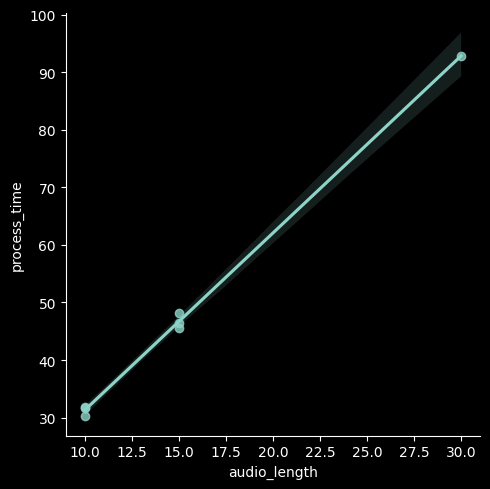

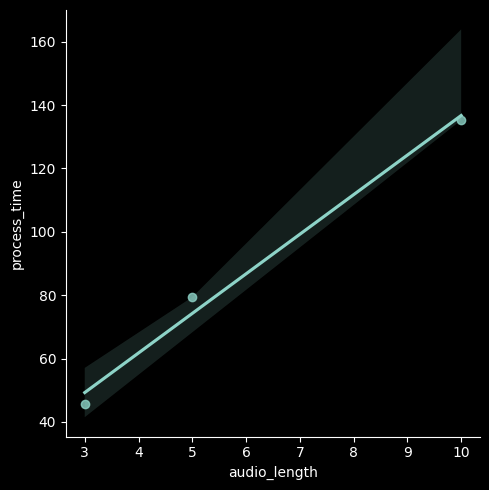

In [5]:
def plot(datas):
    import numpy as np
    datas = np.array(datas)
    from matplotlib import pyplot as plt
    import seaborn as sns
    import pandas as pd
    x_name = "audio_length"
    y_name = "process_time"
    sns.lmplot(x=x_name, y=y_name, data=pd.DataFrame(datas, columns=[x_name, y_name]), 
            fit_reg=True)
    
plot(sad_talker_datas)
plot(rad_nerf_datas)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), LinearRegression())
pip

理论上的性能目标
1s 音频 小于1s生成视频

1s内生成的图片数量 大于 视频帧率

热点优化：
src\facerender\modules\make_animation.py
的 make_animation 函数 

有哪些相关讨论？
关键词：推理、速度、部署、性能、太慢
https://github.com/OpenTalker/SadTalker/issues/625
https://github.com/OpenTalker/SadTalker/issues/309
https://github.com/OpenTalker/SadTalker/issues/110
https://github.com/OpenTalker/SadTalker/issues/520


有哪些人已经尝试对SadTalker做优化？

1. 把face render加速
 轻量化：facevid2vid 换成 pirender 
https://github.com/OpenTalker/SadTalker/discussions/457

半精度
https://github.com/OpenTalker/SadTalker/pull/704

2. CPU优化，部署AMD
https://github.com/Spycsh/xtalker

3. 加速Face Enhancer，优化文件复制
 https://github.com/kenwaytis/faster-SadTalker-API


4. 引入triton
https://zhuanlan.zhihu.com/p/574146311
https://github.com/foocker/SadTalkerTriton

5. 服务协议
“目前实现了在生成视频的地方接入rtmp协议，推送到客户端，但是生成视频的地方比较吃gpu性能   4090显卡延迟也很高 ”
https://pytorch.org/audio/master/tutorials/streamwriter_basic_tutorial.html
https://blog.csdn.net/qq_43502221/article/details/122755039

云端部署与web展示，除了hugging face+gradio
https://github.com/OpenTalker/SadTalker/pull/681

加入参考视频，让动作更加自然。
https://github.com/Zz-ww/SadTalker-Video-Lip-Sync

Pytorch 对于 部署优化的一些尝试

torch.fx
https://pytorch.org/docs/stable/fx.html
https://zhuanlan.zhihu.com/p/428735136
用Python定义的静态图，反射代码。有了图的中间表示，可以在Python中进行代码修改。不支持if-else等控制流。fx 也不支持可变状态和别名？
导出方式是torch.fx.symbolic_trace，是一种trace，需要跑一遍。
fx是Python表示的，所以比起torchscript更加简单，依赖于Python运行时，可以捕获的更加准确。
一般不会有加速效果，仅仅是改代码用的。

torchscript
https://zhuanlan.zhihu.com/p/585829220
python无关的模型表示，保存到文件。与onnx是类似的定位，只不过仅仅支持pytorch模型。
导出方式，torch.jit 模块
- trace
不能有 if-else 等控制流
只支持 Tensor 操作。不支持非Tensor 操作，如List、Tuple、Map 等容器操作。
导出onnx复用了trace
这个得到的结果实际上就是torch.fx? 不对，API看着很像，但是不是同一个东西。可以看看这个讨论
https://discuss.pytorch.org/t/torch-fx-vs-torch-jit-script/100299/4

- script
一个完整的编译器，把Pytorch代码编译为torchscript表示。

加速的预期：GPU上减少一半latency https://zhuanlan.zhihu.com/p/662758224

onnx
https://zhuanlan.zhihu.com/p/456770536


torch.compile
https://zhuanlan.zhihu.com/p/630933479
- Dynamo
定义为Frontend，指的是编译器的前端，就是代码变成中间表示。
是fx的升级，支持更多的语法。得到的结果也是 torch.fx.GraphModule
- AOT Autograd
训练加速，所以这里在考虑怎么编译autograd
- PrimTorch
- TorchInductor

torch tensorrt
https://github.com/pytorch/TensorRT

openai triton

nvidia 对于 深度学习部署的一些概念
GPU驱动

基于GPU指令集之上的基本编程模型：
- CUDA, OpenCL 用于通用计算
- DirectX, OpenGL 用于图形渲染

针对深度学习的SDK
https://blog.csdn.net/weixin_42370067/article/details/106135411
- cuDNN 提供一些算子的CUDA实现？可以用于训练和推理
https://developer.nvidia.com/rdp/cudnn-archive
- TensorRT 提供一些算子的CUDA实现？只能用于推理？是基于cuDNN的？
https://developer.nvidia.com/nvidia-tensorrt-7x-download

判断是否成功安装
nvidia-smi 是驱动
nvcc -V 是CUDA
在where.exe nvcc 中找到cuDNN和TensorRT的文件
<!-- $env:CUDA_HOME/ -->

https://github.com/microsoft/onnxruntime/issues/11826


In [ ]:
import tensorrt as trt
if __name__ == "__main__":
    print(trt.__version__)
    print("hello trt!!")